# Data collection

## Install and import packages

In [11]:
# 必要なパッケージをインストール
%pip install praw pandas matplotlib

# パッケージの読み込み
import praw
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import os

Note: you may need to restart the kernel to use updated packages.


## Parameters

In [12]:
%load_ext dotenv
%dotenv

# パラメータの宣言
REDDIT_CLIENT_ID=os.getenv('REDDIT_CLIENT_ID')
REDDIT_CLIENT_SECRET=os.getenv('REDDIT_CLIENT_SECRET')
REDDIT_USER_AGENT=os.getenv('REDDIT_USER_AGENT')
SUBREDDITS = ['Palestine', 'Israel', 'IsraelPalestine']  # 対象のサブレディットをリストとして定義
TIME_PERIOD_DAYS = 90  # 3か月分の日数

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## Fetch posts

In [13]:
def fetch_submissions(subreddits, days):
    reddit = praw.Reddit(client_id=REDDIT_CLIENT_ID,
                         client_secret=REDDIT_CLIENT_SECRET,
                         user_agent=REDDIT_USER_AGENT)
    
    submissions = []
    end_time = datetime.utcnow()
    start_time = end_time - timedelta(days=days)

    for subreddit in subreddits:
        for submission in reddit.subreddit(subreddit).new(limit=None):
            if datetime.utcfromtimestamp(submission.created_utc) < start_time:
                break  # 期間外の投稿をスキップ
            submissions.append({
                'id': submission.id,
                'title': submission.title,
                'created_utc': datetime.utcfromtimestamp(submission.created_utc),
                'score': submission.score,
                'url': submission.url,
                'text': submission.selftext,
            })
    
    return pd.DataFrame(submissions)


## Save data to csv

In [14]:
def save_to_csv(df, subreddits):
    # 現在の日付を取得
    date_str = datetime.now().strftime('%Y%m%d_%H%M%S')
    # サブレディット名を結合し、ファイル名を生成
    subreddit_str = '_'.join(subreddits)
    filename = f'submissions_{subreddit_str}_{date_str}.csv'
    df.to_csv(filename, index=False)
    print(f'Data saved to {filename}')


## Visualization

In [15]:
def plot_statistics(df):
    df['created_utc'] = pd.to_datetime(df['created_utc'])
    df.set_index('created_utc', inplace=True)
    
    # 日別の投稿数を集計
    daily_counts = df.resample('D').size()
    
    plt.figure(figsize=(12, 6))
    plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-')
    plt.title('Daily Submissions Count')
    plt.xlabel('Date')
    plt.ylabel('Number of Submissions')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

## Main

Data saved to submissions_Palestine_Israel_IsraelPalestine_20241026_173259.csv


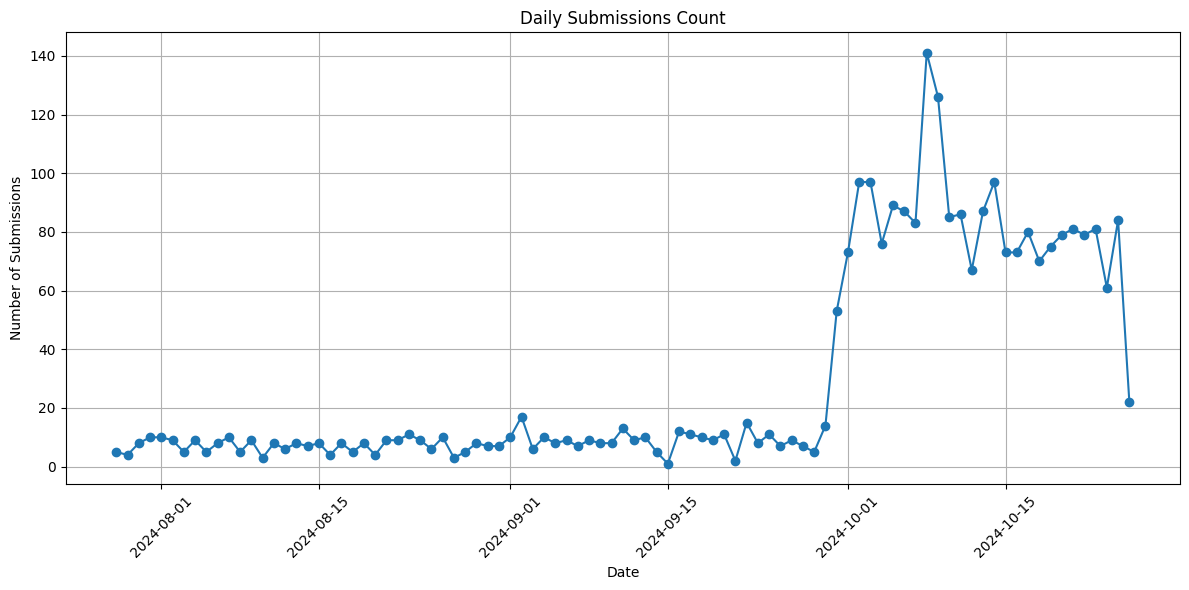

In [16]:
if __name__ == '__main__':
    submissions_df = fetch_submissions(SUBREDDITS, TIME_PERIOD_DAYS)
    save_to_csv(submissions_df, SUBREDDITS)
    plot_statistics(submissions_df)